# Sentiment Analysis Using Natural Language Processing (NLP) and Machine Learning

**Group Members:**

Amarachukwu Owulu - 8923561

Jennifer Agu - 8882641

Kenechukwu Ifediorah - 9052693

**Objective:**

This project is aimed at performing sentiment analysis on about 1.6 million tweets and classifying them into "Negative", "Neutral" and "Positive" tweets. We will utilize several NLP techniques to pre-process the data and extract text features from the tweets which we will then use to train machine learning models to classify the tweets into the classes of sentiments we have.

In [56]:
# Import relevant libraries
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from datasets import Dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel
import torch
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Collection <br><br>

#### (i.) Load the tweets dataset

In [ ]:
df = pd.read_csv('./drive/MyDrive/PROG8245/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')
df.columns = ['target', 'tweet_id', 'date', 'query', 'user_id', 'tweet']
df.head()

,target,tweet_id,date,query,user_id,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
df_small = df.sample(300000)
df_small.head()

,target,tweet_id,date,query,user_id,tweet
527143,0,2194526491,Tue Jun 16 09:54:52 PDT 2009,NO_QUERY,FSTZ,"RIP HONCHO, you will be missed sad day for du..."
1584696,4,2190595248,Tue Jun 16 03:10:44 PDT 2009,NO_QUERY,wow_nK,left school early once again
1238712,4,1993351899,Mon Jun 01 10:14:19 PDT 2009,NO_QUERY,Jesuslovesmeyay,I'm back to twittering I forgot about it beca...
1137808,4,1976778274,Sat May 30 19:02:37 PDT 2009,NO_QUERY,Maubys,@HappyMomAmy I commented on my own sleep trai...
20302,0,1557044100,Sun Apr 19 01:42:03 PDT 2009,NO_QUERY,tai927,@amym21 Awwwww Your dad stil hasn't sorted ev...


In [ ]:
df_small.shape

(300000, 6)

In [ ]:
df_small.to_csv('./drive/MyDrive/PROG8245/tweets.csv', index = False)

In [ ]:
df = pd.read_csv('./drive/MyDrive/PROG8245/tweets.csv')
df.head()

,target,tweet_id,date,query,user_id,tweet
0,0,2194526491,Tue Jun 16 09:54:52 PDT 2009,NO_QUERY,FSTZ,"RIP HONCHO, you will be missed sad day for du..."
1,4,2190595248,Tue Jun 16 03:10:44 PDT 2009,NO_QUERY,wow_nK,left school early once again
2,4,1993351899,Mon Jun 01 10:14:19 PDT 2009,NO_QUERY,Jesuslovesmeyay,I'm back to twittering I forgot about it beca...
3,4,1976778274,Sat May 30 19:02:37 PDT 2009,NO_QUERY,Maubys,@HappyMomAmy I commented on my own sleep trai...
4,0,1557044100,Sun Apr 19 01:42:03 PDT 2009,NO_QUERY,tai927,@amym21 Awwwww Your dad stil hasn't sorted ev...


In [ ]:
df.iloc[1263]['tweet']

'is feeling a little weird with the music tonight. so very very tired. maybe its the caffeine on that salad. '

#### (ii.) Annotate the dataset with huggingface api

In [ ]:
# Model that supports POSITIVE, NEUTRAL, NEGATIVE
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)
print(classifier("I loved Star Wars so much!"))
print(classifier('I dived many times for the ball. Managed to save 50%  The rest go out of bounds'))
print(classifier('I reall dont like going to the gym'))

Device set to use cuda:0


[{'label': 'LABEL_2', 'score': 0.9895804524421692}]
[{'label': 'LABEL_1', 'score': 0.686110258102417}]
[{'label': 'LABEL_0', 'score': 0.9729853868484497}]


In [ ]:
# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Apply pipeline in batch
results = classifier(dataset['tweet'],
                     batch_size=16,
                     truncation=True,
                     max_length=512
                    )

# Map label codes to strings
label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}
df['label'] = [label_map[r['label']] for r in results]
df['score'] = [r['score'] for r in results]

In [ ]:
df.head()

,target,tweet_id,date,query,user_id,tweet,label,score
0,0,2194526491,Tue Jun 16 09:54:52 PDT 2009,NO_QUERY,FSTZ,"RIP HONCHO, you will be missed sad day for du...",negative,0.520675
1,4,2190595248,Tue Jun 16 03:10:44 PDT 2009,NO_QUERY,wow_nK,left school early once again,positive,0.528886
2,4,1993351899,Mon Jun 01 10:14:19 PDT 2009,NO_QUERY,Jesuslovesmeyay,I'm back to twittering I forgot about it beca...,neutral,0.483491
3,4,1976778274,Sat May 30 19:02:37 PDT 2009,NO_QUERY,Maubys,@HappyMomAmy I commented on my own sleep trai...,neutral,0.524293
4,0,1557044100,Sun Apr 19 01:42:03 PDT 2009,NO_QUERY,tai927,@amym21 Awwwww Your dad stil hasn't sorted ev...,negative,0.868442


In [ ]:
df['label'].value_counts()

,count
label,
positive,113163
negative,94969
neutral,91868


In [ ]:
df_new = df.drop(columns=['target', 'score'], axis = 1)

In [ ]:
df_new.to_csv("./drive/MyDrive/PROG8245/labeled_tweets.csv", index = False)

In [25]:
df_labeled = pd.read_csv("./drive/MyDrive/PROG8245/labeled_tweets.csv")
df_labeled.head(3)

,tweet_id,date,query,user_id,tweet,label
0,2194526491,Tue Jun 16 09:54:52 PDT 2009,NO_QUERY,FSTZ,"RIP HONCHO, you will be missed sad day for du...",negative
1,2190595248,Tue Jun 16 03:10:44 PDT 2009,NO_QUERY,wow_nK,left school early once again,positive
2,1993351899,Mon Jun 01 10:14:19 PDT 2009,NO_QUERY,Jesuslovesmeyay,I'm back to twittering I forgot about it beca...,neutral


In [26]:
df_reduced = (
    df_labeled
    .groupby('label', group_keys=False)
    .apply(lambda x: x.sample(frac=100_000 / len(df_labeled), random_state=42)))


<ipython-input-26-4b77fee53cbe>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=100_000 / len(df_labeled), random_state=42)))


In [28]:
df_reduced.to_csv("./drive/MyDrive/PROG8245/labeled_tweets_reduced.csv", index = False)

In [4]:
df_new = pd.read_csv("./drive/MyDrive/PROG8245/labeled_tweets_reduced.csv")
df_new.head(3)

,tweet_id,date,query,user_id,tweet,label
0,1975137469,Sat May 30 14:31:30 PDT 2009,NO_QUERY,781994,not impressed that i have to go to school on m...,negative
1,1977526152,Sat May 30 21:09:00 PDT 2009,NO_QUERY,maljackson,Lost my match lol now gunna be in a rumble,negative
2,2055439473,Sat Jun 06 09:19:08 PDT 2009,NO_QUERY,demolishunn,Got distracted by the internet (as usual). La...,negative


There are no missing values in the data set. We will go ahead to preprocess the data and prepare it for training

## 2. Data Preprocessing

#### (i.) Handling specific cases and special chracters

In [5]:
# Drop irrelevant columns
df_clean = df_new.drop(columns=['tweet_id', 'date', 'query', 'user_id'], axis = 1)
df_clean.head()

,tweet,label
0,not impressed that i have to go to school on m...,negative
1,Lost my match lol now gunna be in a rumble,negative
2,Got distracted by the internet (as usual). La...,negative
3,ahhh my right ear is blocked and i can't hear ...,negative
4,@Showmasters Three guests from Red Dwarf??? My...,negative


Now that we have dropped irrelevant columns, we will handle specific cases like hashtags, urls, and tweet user ids e.g (@iam_khosee)

In [6]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re
                   .MULTILINE)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#', '', tweet)

    # Remove special characters
    tweet = re.sub(r'[^a-zA-Z0-9\s]', ' ', tweet)

    tweet = tweet.replace('  ', ' ')

    tweet = tweet.strip()

    return tweet

In [7]:
df_clean['tweet'] = df_clean['tweet'].apply(clean_tweet)
df_clean.head()

,tweet,label
0,not impressed that i have to go to school on m...,negative
1,Lost my match lol now gunna be in a rumble,negative
2,Got distracted by the internet as usual Laund...,negative
3,ahhh my right ear is blocked and i can t hear ...,negative
4,Three guests from Red Dwarf My son will be so...,negative


Now, we will handle emojis and slangs

In [12]:
def remove_emojis(text):
    return emoji.demojize(text)

# Apply remove_emojis function to 'tweet' column
df_clean['tweet'] = df_clean['tweet'].apply(remove_emojis)
df_clean.head(1)

,tweet,label
0,not impressed that i have to go to school on m...,negative


Handling slang words

In [13]:
slang_dict = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "lol": "laughing out loud",
    "omg": "oh my god",
    "idk": "i don't know",
    "btw": "by the way",
    "brb": "be right back",
    "b4": "before",
    "gr8": "great",
    "l8r": "later",
    "thx": "thanks",
    "pls": "please",
    "plz": "please",
    "y": "why",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "afaik": "as far as i know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "irl": "in real life",
    "jk": "just kidding",
    "np": "no problem",
    "wtf": "what the fuck",
    "wth": "what the hell",
    "bff": "best friends forever",
    "dm": "direct message",
    "fomo": "fear of missing out",
    "ftw": "for the win",
    "gg": "good game",
    "hmu": "hit me up",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "nvm": "never mind",
    "noob": "newbie",
    "tbt": "throwback thursday",
    "ttyl": "talk to you later",
    "wyd": "what are you doing",
    "yolo": "you only live once",
    "ikr": "i know right",
    "ily": "i love you",
    "omw": "on my way",
    "gonna": "going to",
    "wanna": "want to",
    "gotta": "got to",
    "rip": "rest in peace"
}

def replace_slang(text):
    words = text.split()
    replaced_words = [slang_dict.get(word.lower(), word.lower()) for word in words]
    return ' '.join(replaced_words)


In [14]:
df_clean['tweet'] = df_clean['tweet'].apply(replace_slang)
df_clean.head(1)

,tweet,label
0,not impressed that i have to go to school on m...,negative


#### (ii.) Performing text pre-processing (tokenization, lemmatization, stopwords removal, normalization, etc.)

In [15]:
def preprocess_tweet(tweet):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    # Tokenize tweet
    tokens = word_tokenize(tweet)
    pos_tokens = pos_tag(tokens)
    processed_tokens = []
    for token, pos in pos_tokens:
      if token.lower() not in stop_words and token.isalpha():
        #  Map POS tag to WordNet-compatible tag
        pos_map = (
            wordnet.ADJ if pos.startswith('J') else
            wordnet.VERB if pos.startswith('V') else
            wordnet.NOUN if pos.startswith('N') else
            wordnet.ADV if pos.startswith('R') else
            wordnet.NOUN # The default noun tag
        )
        processed_tokens.append(lemmatizer.lemmatize(token.lower(), pos_map))
    return processed_tokens

In [17]:
df_clean['tweet_token'] = df_clean['tweet'].apply(preprocess_tweet)
df_clean.head(5)

,tweet,label,tweet_token
0,not impressed that i have to go to school on m...,negative,"[impressed, go, school, monday, tuesday, cause..."
1,lost my match laughing out loud now gunna be i...,negative,"[lose, match, laugh, loud, gunna, rumble]"
2,got distracted by the internet as usual laundr...,negative,"[got, distract, internet, usual, laundry, do, ..."
3,ahhh my right ear is blocked and i can t hear ...,negative,"[ahhh, right, ear, block, hear, properly]"
4,three guests from red dwarf my son will be so ...,negative,"[three, guest, red, dwarf, son, gutted, come, ..."


In [16]:
# Downloadable file
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [18]:
df_clean.iloc[2]['tweet']

'got distracted by the internet as usual laundry s been done for about an hour now and now i have to stay up later to get it dry'

In [19]:
df_clean.iloc[2]['tweet_token']

['got',
 'distract',
 'internet',
 'usual',
 'laundry',
 'do',
 'hour',
 'stay',
 'later',
 'get',
 'dry']

## 3. Feature Extraction and Model Comparison

#### (i.) Explore different feature representation
- Count-based (TF-IDF)
- Prediction-based (GloVe)
- Contextual embeddings (GPT)

a.) TF-IDF

In [20]:
X = df_clean['tweet_token'].tolist()   # List of tweets for feature extraction
y = df_clean['label'].tolist()    # List of sentiment labels

In [21]:
# TF-IDF Vectorizer
X_text = [" ".join(tokens) for tokens in X]

# 2. Apply TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

print("TF-IDF Shape:", X_tfidf.shape)

TF-IDF Shape: (100000, 45343)


#### b.) GloVe

In [22]:
# Load GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove

--2025-04-17 20:28:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-17 20:28:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-17 20:28:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [27]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [28]:
# Using the 100 dimensions glove file

glove_embeddings = load_glove_embeddings('glove/glove.6B.100d.txt')

In [29]:
def average_glove(tokens, embeddings, dim=100):
    vectors = [embeddings[word] for word in tokens if word in embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [30]:
X_glove = np.array([average_glove(tokens, glove_embeddings) for tokens in X])
print("GloVe Shape:", X_glove.shape)

GloVe Shape: (100000, 100)


#### c.) GPT

In [46]:
from transformers import GPT2Tokenizer, GPT2Model

In [47]:
tweets = [" ".join(tokens) for tokens in X]

In [48]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token
model = GPT2Model.from_pretrained("gpt2")
model.eval()

embeddings = []
embedding_dim = model.config.hidden_size  # 768 for gpt2

for tweet in tqdm(tweets):
    if not tweet.strip():
        # Empty sentence → use zero vector
        embeddings.append(torch.zeros(embedding_dim))
        continue

    try:
        inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)

        if outputs.last_hidden_state.shape[1] == 0:
            embeddings.append(torch.zeros(embedding_dim))  # fallback
        else:
            tweet_embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
            embeddings.append(tweet_embedding)
    except Exception as e:
        print(f"Error with tweet: '{tweet[:30]}...', using zero vector. Error: {e}")
        embeddings.append(torch.zeros(embedding_dim))

100%|██████████| 100000/100000 [2:13:04<00:00, 12.52it/s]


In [32]:
print(len(embeddings))
print(embeddings[0].shape)

100000
torch.Size([768])


In [50]:
# Save embeddings as pt file
torch.save(torch.stack(embeddings), "./drive/MyDrive/PROG8245/embedding_matrix.pt")

In [31]:
embeddings = torch.load("./drive/MyDrive/PROG8245/embedding_matrix.pt")

In [51]:
# Converting to numpy
embedding_matrix = torch.stack(embeddings).numpy()

In [34]:
embedding_matrix.shape

(100000, 768)

In [53]:
# Save embeddings as np file
np.save("./drive/MyDrive/PROG8245/embedding_matrix.npy", embedding_matrix)

In [33]:
embedding_matrix = np.load("./drive/MyDrive/PROG8245/embedding_matrix.npy")

#### (ii.) Model Building

In [35]:
def encode_label(label):
    label_map = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }
    return label_map[label]

df_clean['target'] = df_clean['label'].apply(encode_label)
df_clean.head()

,tweet,label,tweet_token,target
0,not impressed that i have to go to school on m...,negative,"[impressed, go, school, monday, tuesday, cause...",0
1,lost my match laughing out loud now gunna be i...,negative,"[lose, match, laugh, loud, gunna, rumble]",0
2,got distracted by the internet as usual laundr...,negative,"[got, distract, internet, usual, laundry, do, ...",0
3,ahhh my right ear is blocked and i can t hear ...,negative,"[ahhh, right, ear, block, hear, properly]",0
4,three guests from red dwarf my son will be so ...,negative,"[three, guest, red, dwarf, son, gutted, come, ...",0


In [36]:
y = df_clean['target']

#### **Train RandomForestClassifier**

a.) Using TF-IDF Features

In [37]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, y, test_size=0.2, stratify = y, random_state=42)

In [38]:
y_train_tf.shape

(80000,)

In [39]:
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 1, n_jobs=-1)
rf_tfidf.fit(X_train_tf, y_train_tf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.3min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [40]:
# Evaluate Accuracy on Testing set
y_pred_tf = rf_tfidf.predict(X_test_tf)
accuracy_tf = accuracy_score(y_test_tf, y_pred_tf)
print(f"Accuracy: {accuracy_tf:.2f}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.7s


Accuracy: 0.71


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    9.7s finished


              precision    recall  f1-score   support

           0       0.74      0.69      0.71      6331
           1       0.63      0.65      0.64      6125
           2       0.76      0.78      0.77      7544

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:


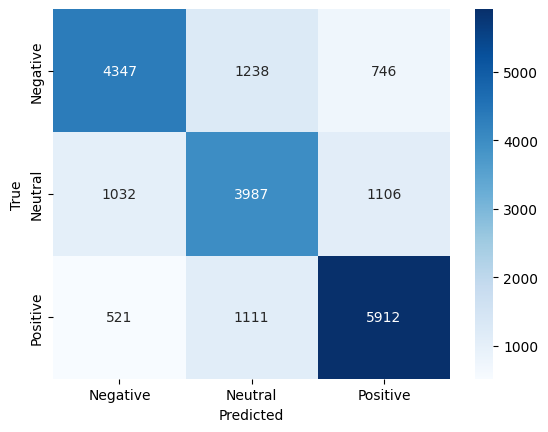

In [45]:
# Check Classification score and confusion matrix
print(classification_report(y_test_tf, y_pred_tf))

# Confusion matrix
conf_matrix_tf = confusion_matrix(y_test_tf, y_pred_tf)
print("Confusion Matrix:")

# plot confusion matrix with label names (0 = Negative, 1 = Neutral, 2 = Positive)
sns.heatmap(conf_matrix_tf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

b.) Using GloVe Features

In [47]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = train_test_split(X_glove, y, test_size=0.2, stratify = y, random_state=42)

In [48]:
rf_glove = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 1, n_jobs=-1)
rf_glove.fit(X_train_gl, y_train_gl)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [49]:
# Evaluate Accuracy on Testing set
y_pred_gl = rf_glove.predict(X_test_gl)
accuracy_gl = accuracy_score(y_test_gl, y_pred_gl)
print(f"Accuracy: {accuracy_gl:.2f}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s


Accuracy: 0.62


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished


              precision    recall  f1-score   support

           0       0.62      0.61      0.61      6331
           1       0.58      0.52      0.55      6125
           2       0.65      0.72      0.68      7544

    accuracy                           0.62     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.62      0.62     20000

Confusion Matrix:


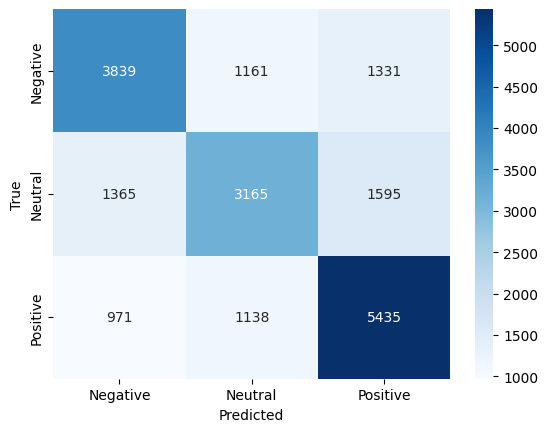

In [50]:
# Check Classification score and confusion matrix
print(classification_report(y_test_gl, y_pred_gl))

# Confusion matrix
conf_matrix_gl = confusion_matrix(y_test_gl, y_pred_gl)
print("Confusion Matrix:")

# plot confusion matrix with label names (0 = Negative, 1 = Neutral, 2 = Positive)
sns.heatmap(conf_matrix_gl, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

a.) Using GPT Features

In [51]:
X_train_gpt, X_test_gpt, y_train_gpt, y_test_gpt = train_test_split(embedding_matrix, y, test_size=0.2, stratify = y, random_state=42)

In [52]:
rf_gpt = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 1, n_jobs=-1)
rf_gpt.fit(X_train_gpt, y_train_gpt)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.1min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [53]:
# Evaluate Accuracy on Testing set
y_pred_gpt = rf_gpt.predict(X_test_gpt)
accuracy_gpt = accuracy_score(y_test_gpt, y_pred_gpt)
print(f"Accuracy: {accuracy_gpt:.2f}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s


Accuracy: 0.61


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished


              precision    recall  f1-score   support

           0       0.60      0.59      0.60      6331
           1       0.57      0.49      0.53      6125
           2       0.64      0.72      0.68      7544

    accuracy                           0.61     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.61      0.60     20000

Confusion Matrix:


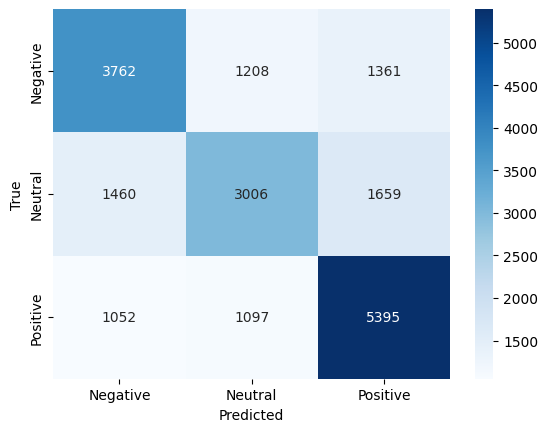

In [54]:
# Check Classification score and confusion matrix
print(classification_report(y_test_gpt, y_pred_gpt))

# Confusion matrix
conf_matrix_gpt = confusion_matrix(y_test_gpt, y_pred_gpt)
print("Confusion Matrix:")

# plot confusion matrix with label names (0 = Negative, 1 = Neutral, 2 = Positive)
sns.heatmap(conf_matrix_gpt, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Final Summary and Conclusion**

In this Project we implemented three different feature extraction methods for representing tweets for sentiment analysis. We used the TF-IDF from count-based, GloVe embeddings from Precision based and GPT embeddings from Contextual embeddings. For the Machine Learning algorithm we used the Random Forest classifier which is an ensemble machine learning model that has the capacity to manage high dimensional data and multi classification tasks. So we trained using feature sets produced by the different feature extraction methods.


| Feature Extraction Method | Testing Accuracy | Precision | Recall | F1-Score | Observations |
|:---------------------------|:-----------------|:----------|:-------|:---------|:-------------|
| **TF-IDF + Random Forest**  | 71%               | 0.71      | 0.71   | 0.71     | Strong baseline; handles sparse features well but lacks semantic and contextual understanding. |
| **GloVe + Random Forest**   | 62%               | 0.62      | 0.61   | 0.61     | Captures semantic meaning better than TF-IDF but still struggles with sentence-level context. |
| **GPT Embeddings + Random Forest** | 61%        | 0.60      | 0.60   | 0.60     | Despite context-awareness, Random Forest could not fully leverage deep embeddings' power. |


**TF-IDF Feature Extraction**

To give a balance assessments of the model's capacity for generalization, the dataset was divided into training and testing dataset subsets using stratify.
The TF-IDF based feature extraction model have the overall best classification performance with a testing accuracy of 71% and associated precision, recall, and F1-scores of roughly 0.71. The most important phrases pertaining to sentiment polarity in the tweets were successfully captured by the TF-IDF representation, despite its simplicity.  This shows that traditional(count based) methods can be incredibly effective when paired with the right machine learning models, especially in cases when contextual specifics are less important or the data is noisy.

**GloVe Feature Extraction**

On the other hand, the model that was trained using GloVe embeddings produced results that were reasonable, with an F1-score of 0.61 and an accuracy of 62%.  GloVe vectors are static embeddings that use the co-occurrence statistics of words to capture their semantic links.  However, their efficacy for sentiment analysis tasks where a word's meaning might drastically change depending on its neighbouring terms was restricted by their inability to incorporate dynamic context.  Therefore, even though GloVe offered more comprehensive semantic characteristics than TF-IDF, it was unable to considerably improve classification results in the Random Forest framework.

**GPT Feature Extraction**

Interestingly, the model using GPT embeddings performed the worst out of the three, with an F1-score of around 0.60 and a testing accuracy of 61%.  Theoretically, GPT embeddings provide a profound, context-sensitive knowledge of language, but in this instance, their effectiveness was compromised.  The likely reasons are the feature aggregation technique (e.g., simple averaging across token embeddings), which might have eliminated subtle context, and Random Forest models' intrinsic inability to fully utilise the dense, high-dimensional representations generated by large language models.  There may have been a mismatch between feature complexity and classifier type in this work, as transformer-based embeddings usually require end-to-end deep learning models to obtain maximum performance.

**Conclusion**

To sum everything up, when combined with a Random Forest classifier, TF-IDF was the most successful feature extraction method for this sentiment classification assignment.  In spite of the growing number of advanced embedding models, conventional techniques are still quite competitive, particularly when using classical machine learning techniques.